run this

In [1]:
%load_ext autoreload
%autoreload 2
# Enable imports form top-level of project (edit top_level_path accordingly)
import os
import sys
import inspect

top_level_path = os.path.abspath(os.path.join('..'))
if top_level_path not in sys.path:
	sys.path.append(top_level_path)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from longestpath.gen import gen_num_edges, gen_num_edges_undirected
from benchmarking import RandomParams, Benchmark, new_random_benchmark, Solver, new_graph_file_benchmark, new_benchmark
import re

In [167]:
def generate():
  return [
    gen_num_edges_undirected(30, round(30 * degree / 2))
      for degree in np.arange(1.2, 3.7,0.2) for _ in range(50)
      # np.arange(1, 3.3, 0.3) for _ in range(1)
  ]

params_code = inspect.getsource(generate)
graphs = generate()

benchmark = new_benchmark(graphs, solvers=[
	Solver("brute", "FAST_BOUND"),
	Solver("brute", "BRUTE_FORCE"),
	Solver("brute", "BRANCH_N_BOUND"),
	Solver("brute", "BRUTE_FORCE_COMPLETE"),
  Solver("ilp"),
	Solver("kalp", threads=4),
	Solver("kalp"),
], params_code = params_code, override_benchmark_path="../benchmarks/all_methods_1.2-3.6_50_runs")

benchmark.benchmark_path


'../benchmarks/all_methods_1.2-3.6_50_runs(1)'

In [168]:
np.arange(1.2, 3.7,0.2)

array([1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6])

run this

In [2]:
benchmark = Benchmark.load("../final_benchmarks/all_methods_1.2-3.6_50_runs_latest/")

In [169]:
benchmark.run(retryFailures=True, timeout=10 * 60)


graph: 0.txt, solver: brute('FAST_BOUND') ... 

✅
length: 7, run_time: 6e-06
graph: 1.txt, solver: brute('FAST_BOUND') ... ✅
length: 10, run_time: 1e-05
graph: 2.txt, solver: brute('FAST_BOUND') ... ✅
length: 5, run_time: 7e-06
graph: 3.txt, solver: brute('FAST_BOUND') ... ✅
length: 6, run_time: 5e-06
graph: 4.txt, solver: brute('FAST_BOUND') ... ✅
length: 12, run_time: 7e-06
graph: 5.txt, solver: brute('FAST_BOUND') ... ✅
length: 7, run_time: 6e-06
graph: 6.txt, solver: brute('FAST_BOUND') ... ✅
length: 8, run_time: 7e-06
graph: 7.txt, solver: brute('FAST_BOUND') ... ✅
length: 6, run_time: 7e-06
graph: 8.txt, solver: brute('FAST_BOUND') ... ✅
length: 9, run_time: 7e-06
graph: 9.txt, solver: brute('FAST_BOUND') ... ✅
length: 6, run_time: 7e-06
graph: 10.txt, solver: brute('FAST_BOUND') ... ✅
length: 8, run_time: 1e-05
graph: 11.txt, solver: brute('FAST_BOUND') ... ✅
length: 5, run_time: 6e-06
graph: 12.txt, solver: brute('FAST_BOUND') ... ✅
length: 6, run_time: 6e-06
graph: 13.txt, solver: brute('FAST_BOUND') ... ✅
length: 10, run_t

run this and everything after

In [3]:
df_ = benchmark.get_dataframe()
if not "failure" in df_:
    df_["failure"] = None
df = df_
df.head()

,path,run_time,length,solver,graph_id,status,objective_value,failure,solver_name,vertices,edges,average_out_degree
0,"[6, 28, 2, 7, 26, 21, 3, 19]",0.000006,7.0,0,0,NaN,NaN,NaN,brute('FAST_BOUND'),30,36,1.2
1,"[4, 17, 8, 19, 7, 5, 26, 1, 11, 14, 10]",0.000010,10.0,0,1,NaN,NaN,NaN,brute('FAST_BOUND'),30,36,1.2
2,"[4, 15, 25, 20, 14, 29]",0.000007,5.0,0,2,NaN,NaN,NaN,brute('FAST_BOUND'),30,36,1.2
3,"[0, 19, 2, 16, 18, 10, 3]",0.000005,6.0,0,3,NaN,NaN,NaN,brute('FAST_BOUND'),30,36,1.2
4,"[6, 21, 18, 12, 10, 19, 0, 8, 4, 3, 29, 2, 7]",0.000007,12.0,0,4,NaN,NaN,NaN,brute('FAST_BOUND'),30,36,1.2


run_time    Axes(0.125,0.11;0.775x0.77)
dtype: object

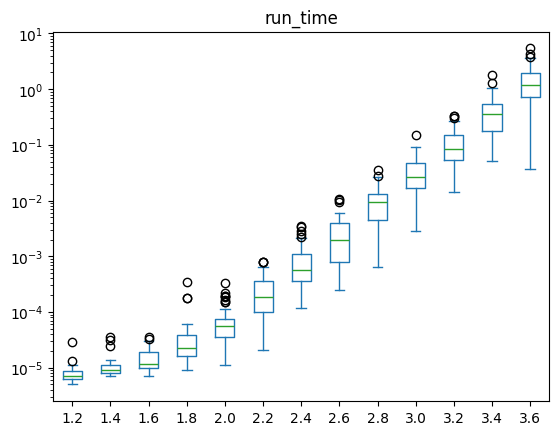

In [4]:
df[df["solver"] == 0][["run_time", "average_out_degree"]].plot.box(by="average_out_degree", logy=True)


In [5]:
df_grouped = df.groupby(['average_out_degree', 'solver', 'solver_name']).agg({"run_time": "mean", "failure": "any"}).reset_index()
df_grouped_failures_removed = df_grouped[df_grouped["failure"] == False]
to_plot = df_grouped_failures_removed.pivot(index='average_out_degree', columns='solver_name', values='run_time').rename(columns=lambda x: x + " (average)")

In [6]:
df_grouped_failures_removed.groupby(["solver_name"]).agg({"failure": "count"}).reset_index().rename(columns={"failure": "count"})

,solver_name,count
0,brute('BRANCH_N_BOUND'),13
1,brute('BRUTE_FORCE'),13
2,brute('BRUTE_FORCE_COMPLETE'),13
3,brute('FAST_BOUND'),13
4,ilp(),10
5,kalp(),13
6,kalp(threads=4),13


In [7]:
df_grouped_failures_removed.head()

,average_out_degree,solver,solver_name,run_time,failure
0,1.2,0,brute('FAST_BOUND'),0.000008,False
1,1.2,1,brute('BRUTE_FORCE'),0.000006,False
2,1.2,2,brute('BRANCH_N_BOUND'),0.000015,False
3,1.2,3,brute('BRUTE_FORCE_COMPLETE'),0.000007,False
4,1.2,4,ilp(),0.987792,False


In [8]:
to_plot


solver_name,brute('BRANCH_N_BOUND') (average),brute('BRUTE_FORCE') (average),brute('BRUTE_FORCE_COMPLETE') (average),brute('FAST_BOUND') (average),ilp() (average),kalp() (average),kalp(threads=4) (average)
average_out_degree,,,,,,,
1.2,0.000015,0.000006,0.000007,0.000008,0.987792,1.052151,1.245375
1.4,0.000022,0.000009,0.000009,0.000010,1.836209,1.132533,1.359332
1.6,0.000052,0.000016,0.000016,0.000015,5.543277,1.295544,1.619271
1.8,0.000137,0.000045,0.000044,0.000039,3.782058,1.430449,1.806507
2.0,0.000342,0.000095,0.000096,0.000074,2.610913,1.679194,2.019431
2.2,0.000891,0.000311,0.000303,0.000255,3.147584,1.813758,2.150219
2.4,0.002958,0.001154,0.001124,0.000877,2.863959,1.937222,2.271151
2.6,0.006994,0.003525,0.003453,0.002645,3.554278,2.068126,2.374166
2.8,0.019706,0.012834,0.012789,0.010055,10.174901,2.290259,2.512711


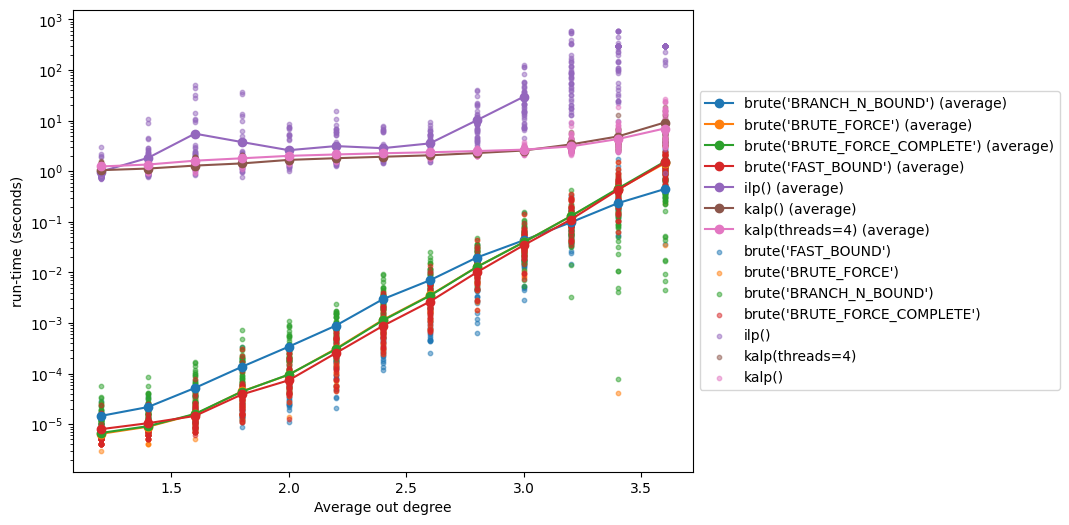

In [9]:
view = df[['average_out_degree', 'solver_name','length', 'run_time']]

# to_plot = df.groupby(['average_out_degree', 'solver', 'solver_name']).agg({'run_time': 'mean'}).reset_index() \
#     .pivot(index='average_out_degree', columns='solver_name', values='run_time') \
#     .rename(columns=lambda x: x + " (average)");

to_plot.plot(style="o-")

for solver_name in benchmark.solver_names():
    solver_df = df[df["solver_name"] == solver_name]  # Select rows where run-time is not null
    plt.scatter(solver_df['average_out_degree'], solver_df['run_time'], label=solver_name, alpha=0.5, s=10)

plt.yscale('log')
# plt.xticks(np.arange(1, 4.0, 0.5))
plt.ylabel("run-time (seconds)")
plt.xlabel("Average out degree")
# plt.title("Longest path solve-time for random directed graphs with 50 vertices")
# plt.axhline(y=0.015, color='black', linestyle='--', label='run-time cutoff', linewidth=1, alpha=0.5, zorder=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# df[df["solver"] == 0].plot(x = "average_degree", y="run_time", style="--bo", label="solver_name")
# df[df["solver"] == 1].plot(x = "average_degree", y="run_time", style="--bo", label="solver_name")
# plt.ylim(0, to_plot.max().max())
# plt.ylim(0, 1)

plt.gcf().set_size_inches(8, 6)
plt.savefig(os.path.join(benchmark.benchmark_path, "plot.png"), dpi=400, bbox_inches='tight')